<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Baselines" data-toc-modified-id="Baselines-1">Baselines</a></span><ul class="toc-item"><li><span><a href="#Test" data-toc-modified-id="Test-1.1">Test</a></span><ul class="toc-item"><li><span><a href="#Motivation" data-toc-modified-id="Motivation-1.1.1">Motivation</a></span></li></ul></li></ul></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-2">Prepare data</a></span><ul class="toc-item"><li><span><a href="#Limit-for-a-smaller-area" data-toc-modified-id="Limit-for-a-smaller-area-2.1">Limit for a smaller area</a></span></li><li><span><a href="#Round-time" data-toc-modified-id="Round-time-2.2">Round time</a></span></li><li><span><a href="#Number-of-requests" data-toc-modified-id="Number-of-requests-2.3">Number of requests</a></span></li><li><span><a href="#Create-grid" data-toc-modified-id="Create-grid-2.4">Create grid</a></span><ul class="toc-item"><li><span><a href="#Area-size" data-toc-modified-id="Area-size-2.4.1">Area size</a></span></li><li><span><a href="#Cells" data-toc-modified-id="Cells-2.4.2">Cells</a></span></li></ul></li></ul></li><li><span><a href="#Predict-demand" data-toc-modified-id="Predict-demand-3">Predict demand</a></span><ul class="toc-item"><li><span><a href="#Total-hourly-demand" data-toc-modified-id="Total-hourly-demand-3.1">Total hourly demand</a></span></li></ul></li></ul></div>

# Baselines

## Test
### Motivation

Create a set of baselines for demand prediction using conventional methods:

* time series prediction
* per cell prediction using any type of regressor, e.g. gradient boosting regressor

# Prepare data

In [75]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [129]:
%%time 

raw_data = pd.read_feather('../data/train_data.feather')

print(f'Dataset shape: {raw_data.shape}\n')
raw_data.head(3)

Dataset shape: (41988051, 8)

CPU times: user 2.04 s, sys: 9.23 s, total: 11.3 s
Wall time: 27.3 s


,pickup_datetime,dropoff_datetime,passenger_count,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,2015-01-01 00:00:00,2015-01-01 00:00:00,3,2.510570,-74.001320,40.729057,-74.010208,40.719662
1,2015-01-01 00:00:03,2015-01-01 00:10:50,1,2.542757,-73.987579,40.765270,-73.976921,40.776970
2,2015-01-01 00:00:03,2015-01-01 00:21:48,2,4.136004,-73.969017,40.754269,-73.994133,40.761600


In [130]:
raw_data.drop(['dropoff_datetime', 'passenger_count', 'distance',
           'dropoff_lon', 'dropoff_lat'], axis=1, inplace=True)

raw_data.columns = ['datetime', 'lon', 'lat']

raw_data.head(3)

,datetime,lon,lat
0,2015-01-01 00:00:00,-74.001320,40.729057
1,2015-01-01 00:00:03,-73.987579,40.765270
2,2015-01-01 00:00:03,-73.969017,40.754269


In [262]:
raw_data.groupby(raw_data.datetime.dt.month).datetime.count()

datetime
1    10489491
2    10143494
3    10773677
4    10581389
Name: datetime, dtype: int64

In [266]:
raw_data = raw_data[raw_data.datetime.dt.month < 5].reset_index(drop=False)

## Limit for a smaller area

Use area selected manually using http://geojson.io/#map=15/40.7357/-73.9889

In [267]:
bbox = ((-73.996, -73.9817), (40.7308, 40.7416))

(min_lon, max_lon), (min_lat, max_lat) = bbox

idx = (raw_data.lat >= min_lat) & (raw_data.lat <= max_lat)
idx = idx & (raw_data.lon >= min_lon) & (raw_data.lon <= max_lon)

print(f'Dataset size: {raw_data.shape[0]}')
print(f'Sample size: {idx.sum()}')

data = raw_data[idx].reset_index(drop=True);

Dataset size: 41988051
Sample size: 2750089


Demand per day stats:

In [268]:
data.datetime.dt.date.value_counts().describe()

count      120.000000
mean     22917.408333
std       3606.016374
min       7588.000000
25%      21055.500000
50%      23054.000000
75%      25072.500000
max      32858.000000
Name: datetime, dtype: float64

## Round time

In [269]:
data.datetime = data.datetime.dt.round('10min')

data.sample(5)

,level_0,index,datetime,lon,lat
590998,9000252,9000252,2015-01-28 06:50:00,-73.995216,40.739506
1697333,25600333,25600333,2015-03-15 11:50:00,-73.994705,40.731747
1705153,25719903,25719903,2015-03-15 18:10:00,-73.985985,40.738323
2503047,38070396,38070396,2015-04-19 21:10:00,-73.995049,40.733883
1443101,21738811,21738811,2015-03-04 14:50:00,-73.985321,40.735706


Create a grid and count the *number of requests per cell*

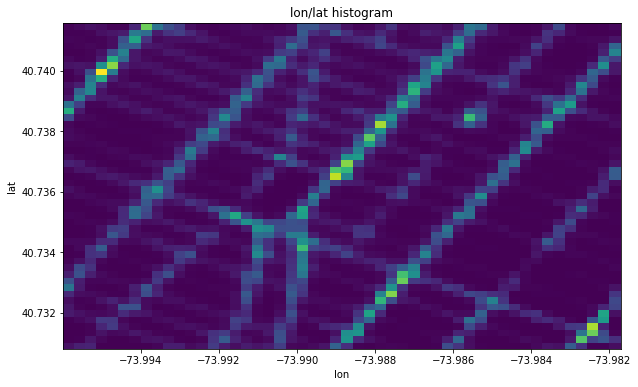

In [270]:
plt.figure(figsize=(10, 6))

plt.hist2d(data.lon, data.lat, bins=50);
plt.title('lon/lat histogram');
plt.xlabel('lon');
plt.ylabel('lat');

## Number of requests

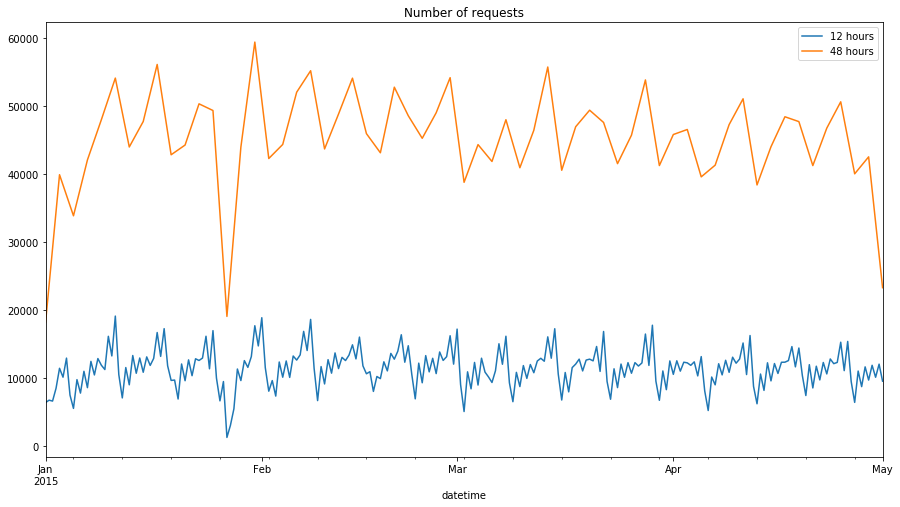

In [271]:
plt.figure(figsize=(15, 8))

plt.title('Number of requests')
data.groupby(
    data.datetime.dt.round('12h')).datetime.count().plot(label='12 hours')
data.groupby(
    data.datetime.dt.round('48h')).datetime.count().plot(label='48 hours')
plt.legend()

## Create grid

### Area size

In [272]:
import haversine

point1 = (bbox[1][0], bbox[0][0])
point2 = (bbox[1][0], bbox[0][1])
point3 = (bbox[1][1], bbox[0][0])

dx = haversine.haversine(point1, point2)
dy = haversine.haversine(point1, point3)

print(f'Area size is {dx:.2f} x {dy:.2f} km')

Area size is 1.20 x 1.20 km


### Cells

Create 50x50 meters cells

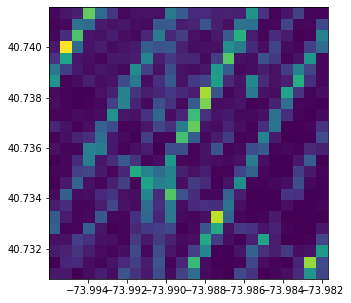

In [273]:
# cell_size x cell_size grid
cell_size = 24

plt.figure(figsize=(5, 5))
plt.hist2d(data.lon, data.lat, bins=cell_size);

In [274]:
%%time 

xcells = np.linspace(bbox[0][0], bbox[0][1], cell_size)
data['x_cell'] = np.digitize(data.lon, xcells)

ycells = np.linspace(bbox[1][0], bbox[1][1], cell_size)
data['y_cell'] = np.digitize(data.lat, ycells)

data['cell'] = data.apply(
    lambda item: '{}-{}'.format(item.x_cell, item.y_cell), axis=1)

data.head(5)

,level_0,index,datetime,lon,lat,x_cell,y_cell,cell
0,12,12,2015-01-01,-73.986000,40.740601,17,21,17-21
1,36,36,2015-01-01,-73.990891,40.738850,9,18,9-18
2,52,52,2015-01-01,-73.990509,40.735027,9,10,9-10
3,59,59,2015-01-01,-73.987442,40.733410,14,6,14-6
4,68,68,2015-01-01,-73.985779,40.731773,17,3,17-3


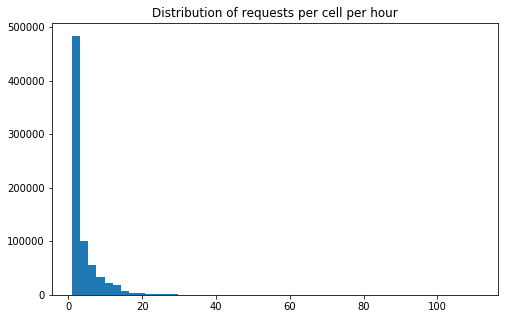

In [286]:
plt.figure(figsize=(8, 5))

plt.title('Distribution of requests per cell per hour')
plt.hist(data.groupby([data.datetime.dt.round('1h'), 'cell']).cell.count(), bins=50);

# Predict demand

## Total hourly demand

In [306]:
demand_data = data.groupby('datetime').size()
demand_data = demand_data.reset_index()
demand_data.columns = ['datetime', 'total']

train_data = demand_data[demand_data.datetime.dt.month < 4]
test_data = demand_data[demand_data.datetime.dt.month == 4]

train_data.shape, test_data.shape

((12926, 2), (4320, 2))

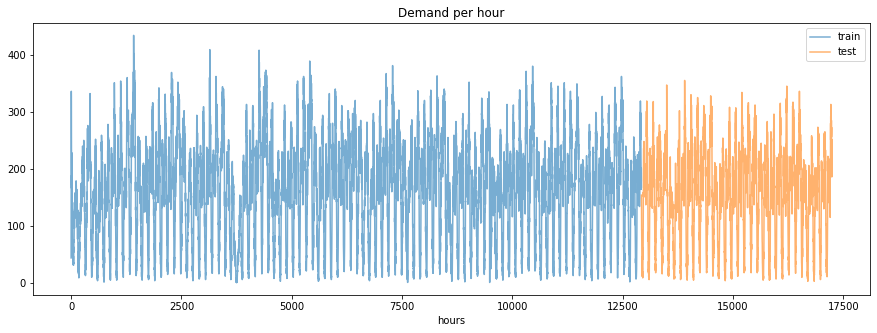

In [310]:
plt.figure(figsize=(15, 5))

plt.title('Demand per hour')
plt.plot(train_data.total, alpha=0.6, label='train')
plt.plot(test_data.total, alpha=0.6, label='test');
plt.xlabel('hours')
plt.legend();